# Determining the most profitable oil production region

Our task is to help an oil production company decide where to drill a new well.

We are provided with oil samples from three regions: each with 10,000 fields, where the oil quality and reserve volume have been measured. We need to build a machine learning model that will help determine the region where production will be most profitable. We will analyze the potential profit and risks using the Bootstrap technique.

Steps for selecting a location:

- Search for deposits in the selected region and determine the values for each;
- Build a model and estimate the reserve volume;
- Select deposits with the highest estimated values. The number of deposits depends on the company's budget and the cost of developing a single well;
- Profit equals the total profit from the selected deposits.

## Loading and preparing data

### Data overview

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from numpy.random import RandomState

In [2]:
# Disable the chain assignment warning
pd.options.mode.chained_assignment = None

In [3]:
# Read all csv files and display the datasets on the screen
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

display(data_0.head())
display(data_1.head())
data_2.head()

id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746

Let's look at the information on the datasets

In [4]:
display(data_0.info())
display(data_1.info())
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Each dataset contains 100,000 records. The dataset structures are identical, with no gaps.

The features in the dataset are as follows:

* `id` — unique well identifier;
* `f0, f1, f2` — three features of wells (we do not know what they mean, but we know that the features themselves are significant);
* `product` — volume of reserves in the well (thousand barrels).

### Preprocessing

#### Data Statistics

Let's look at the descriptive statistics for the datasets.

In [5]:
display(data_0.describe())
display(data_1.describe())
data_2.describe()

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408

f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838

Across all datasets, medians and means are quite close across all parameters. We believe there are no outliers in the data.

#### Handling duplicates

Let's look at the number of unique records for the `id` attribute.

In [6]:
display(data_0.id.nunique())
display(data_1.id.nunique())
data_2.id.nunique()

99990

99996

99996

The datasets contain between 4 and 10 duplicate values in the `id` feature. Let's check the datasets for duplicates.

In [7]:
display(data_0.duplicated().sum())
display(data_1.duplicated().sum())
data_2.duplicated().sum()

0

0

0

All rows in the datasets are unique. Let's look for duplicates in the `id` feature.

In [8]:
data_0[data_0.id.duplicated(keep=False)]

id        f0        f1         f2     product
931    HZww2  0.755284  0.368511   1.863211   30.681774
1364   bxg6G  0.411645  0.856830  -3.653440   73.604260
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
16633  fiKDv  0.157341  1.028359   5.585586   95.817889
21426  Tdehs  0.829407  0.298807  -0.049563   96.035308
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
42529  AGS9W  1.454747 -0.479651   0.683380  126.370504
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
60140  TtcGQ  0.569276 -0.104876   6.440215   85.350186
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
64022  74z30  0.741456  0.459229   5.153109  140.771492
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
89582  bsk9y  0.398908 -0.400253  10.122376  163.433078
90815  fiKDv  0.049883  0.841313   6.394613  137.346586
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
97785  bsk9y  0.378429  0.005837   0.160827  160.637302

In [9]:
data_1[data_1.id.duplicated(keep=False)]

id         f0         f1        f2     product
1305   LHZR0  11.170835  -1.945066  3.002872   80.859783
2721   bfPNe  -9.494442  -5.463692  4.006042  110.992147
5849   5ltQ6  -3.435401 -12.296043  1.999796   57.085625
41906  LHZR0  -8.989672  -4.286607  2.009139   57.085625
47591  wt4Uk  -9.091098  -8.109279 -0.002314    3.179103
82178  bfPNe  -6.202799  -4.820045  2.995107   84.038886
82873  wt4Uk  10.259972  -9.376355  4.994297  134.766305
84461  5ltQ6  18.213839   2.191999  3.993869  107.813044

In [10]:
data_2[data_2.id.duplicated(keep=False)]

id        f0        f1        f2     product
11449  VF7Jo  2.122656 -0.858275  5.746001  181.716817
28039  xCHr8  1.633027  0.368135 -2.378367    6.120525
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641
44378  Vcm5J -1.229484 -2.439204  1.222909  137.968290
45404  KUPhW  0.231846 -1.698941  4.990775   11.716299
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420
55967  KUPhW  1.211150  3.176408  5.543540  132.831802
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572

It's clear that despite having duplicates in the 'id' feature, the other features in the duplicated objects differ. This may be due to repeated borehole measurements. We don't know whether the records in the datasets are in chronological order. The maximum duplicate percentage is 0.0001% of all dataset records.

Let's remove the duplicates, leaving only the records located lower in the dataset. We assume the dataset was populated sequentially. Will check the result.

In [11]:
data_0 = data_0.drop_duplicates(subset='id', keep='last').reset_index(drop=True)
data_1 = data_1.drop_duplicates(subset='id', keep='last').reset_index(drop=True)
data_2 = data_2.drop_duplicates(subset='id', keep='last').reset_index(drop=True)


display(data_0.id.duplicated().sum())
display(data_1.id.duplicated().sum())
data_2.id.duplicated().sum()

0

0

0

#### Removing features

Let's remove the 'id' feature, as it won't provide any useful information to our model. The well ID is a random string of characters and won't help us determine the target feature.

In [12]:
data_0 = data_0.drop('id', axis=1)
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

display(data_0.columns)
display(data_1.columns)
data_2.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

## Training and testing models

### Splitting datasets into samples

We divide each dataset into training and validation samples.

In [13]:
# Split dataset 0 into two samples: training and validation in a ratio of 0.75/0.25
target_0 = data_0['product']
features_0 = data_0.drop('product', axis=1)

features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, target_0, test_size=0.25, random_state=1)

# Check the size of the received samples
display(features_0_train.shape)
features_0_valid.shape

(74992, 3)

(24998, 3)

In [14]:
# Split dataset 1 into two samples: training and validation in a ratio of 0.75/0.25
target_1 = data_1['product']
features_1 = data_1.drop('product', axis=1)

features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=1)

# Check the size of the received samples
display(features_1_train.shape)
features_1_valid.shape

(74997, 3)

(24999, 3)

In [15]:
# Split dataset 2 into two samples: training and validation in a ratio of 0.75/0.25
target_2 = data_2['product']
features_2 = data_2.drop('product', axis=1)

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size=0.25, random_state=1)

# Check the size of the received samples
display(features_2_train.shape)
features_2_valid.shape

(74997, 3)

(24999, 3)

### Feature scaling

Let's scale the features for each dataset.

In [16]:
# Define scalable features
numeric = [
    'f0',
    'f1',
    'f2',
]

In [17]:
# Scale the features in the dataset 0
scaler = StandardScaler()
scaler.fit(features_0_train[numeric])

features_0_train[numeric] = scaler.transform(features_0_train[numeric])
features_0_valid[numeric] = scaler.transform(features_0_valid[numeric])

# Display the scaled training sample on the screen
features_0_train.head()

f0        f1        f2
23482 -0.644986  1.694935 -0.240844
78499 -1.038627  1.529464  1.323512
41891 -0.418261 -0.894233 -1.338430
45458 -0.025129  0.936552  1.148631
63348  1.423971 -1.386338 -1.152141

In [18]:
# Scale the features in the dataset 1
scaler = StandardScaler()
scaler.fit(features_1_train[numeric])

features_1_train[numeric] = scaler.transform(features_1_train[numeric])
features_1_valid[numeric] = scaler.transform(features_1_valid[numeric])

# Display the scaled training sample on the screen
features_1_train.head()

f0        f1        f2
77267  0.046374 -0.766176 -0.876494
64106  1.028877  0.242691 -1.461482
266   -1.047039  0.556037 -1.466914
23482  1.448002  0.259348  0.300477
97588 -1.475084 -0.801688 -0.871130

In [19]:
# Scale the features in the dataset 2
scaler = StandardScaler()
scaler.fit(features_2_train[numeric])

features_2_train[numeric] = scaler.transform(features_2_train[numeric])
features_2_valid[numeric] = scaler.transform(features_2_valid[numeric])

# Display the scaled training sample on the screen
features_2_train.head()

f0        f1        f2
77267 -3.230092 -1.098621  0.024212
64106  1.735345 -1.464009 -1.421983
266   -0.460921 -0.815345 -1.414064
23482  0.985922  0.736131 -1.650855
97588 -0.302063  0.199724 -0.561447

### Training and testing models

We will train a linear regression model for each dataset, make a prediction, and calculate the root mean square error (RMSE) for each model. Then we will display the RMSE, the average predicted raw material inventory, and the average actual raw material inventory on the screen.

In [20]:
model_0 = LinearRegression()
model_0.fit(features_0_train, target_0_train)
predictions_0 = model_0.predict(features_0_valid)
rmse_0_valid = mean_squared_error(target_0_valid, predictions_0, squared=False)

display(f'Model 0 RMSE value: {round(rmse_0_valid, 4)}')
display(f'Predicted average raw material inventory: {round(predictions_0.mean(), 4)} thousand barrels')
f'True average raw material inventory: {round(target_0_valid.mean(), 4)} thousand barrels'

'Значение RMSE модели №0: 37.8304'

'Предсказанный средний запас сырья: 92.5252 тыс. баррелей'

'Истинный средний запас сырья: 92.4565 тыс. баррелей'

In [21]:
model_1 = LinearRegression()
model_1.fit(features_1_train, target_1_train)
predictions_1 = model_1.predict(features_1_valid)
rmse_1_valid = mean_squared_error(target_1_valid, predictions_1, squared=False)

display(f'Model 1 RMSE value: {round(rmse_1_valid, 4)}')
display(f'Predicted average raw material inventory: {round(predictions_1.mean(), 4)} thousand barrels')
f'True average raw material inventory: {round(target_1_valid.mean(), 4)} thousand barrels'

'Значение RMSE модели №1: 0.8899'

'Предсказанный средний запас сырья: 69.0331 тыс. баррелей'

'Истинный средний запас сырья: 69.0376 тыс. баррелей'

In [22]:
model_2 = LinearRegression()
model_2.fit(features_2_train, target_2_train)
predictions_2 = model_2.predict(features_2_valid)
rmse_2_valid = mean_squared_error(target_2_valid, predictions_2, squared=False)

display(f'Model 2 RMSE value: {round(rmse_2_valid, 4)}')
display(f'Predicted average raw material inventory: {round(predictions_2.mean(), 4)} thousand barrels')
f'True average raw material inventory: {round(target_2_valid.mean(), 4)} thousand barrels'

'Значение RMSE модели №2: 39.843'

'Предсказанный средний запас сырья: 95.0644 тыс. баррелей'

'Истинный средний запас сырья: 94.8153 тыс. баррелей'

Model evaluation:

The models for regions #0 and #2 show RMSE values in the range of 37-39. Meanwhile, the model for region #1 showed an RMSE value of 0.8899. This is a remarkable result. The model very accurately predicts the volume of crude oil in the wells. The root mean square error is less than 1,000 barrels. This means that our model is off by an average of 1,000 barrels.

In [23]:
data_1.corr()

f0        f1        f2   product
f0       1.000000  0.182270 -0.001788 -0.030501
f1       0.182270  1.000000 -0.002610 -0.010168
f2      -0.001788 -0.002610  1.000000  0.999397
product -0.030501 -0.010168  0.999397  1.000000

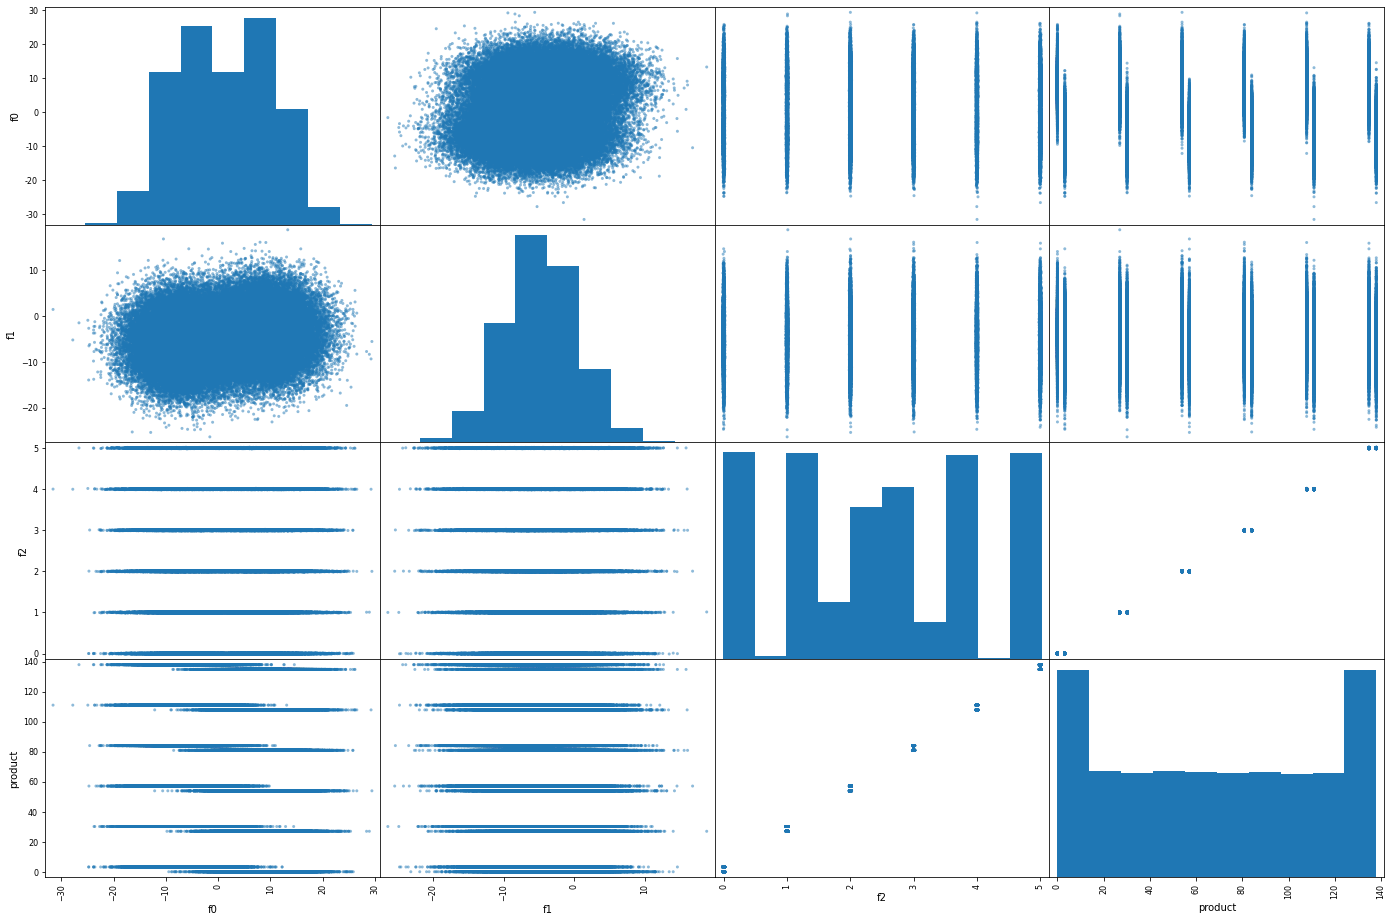

In [24]:
ax = pd.plotting.scatter_matrix(data_1, figsize=(24, 16))

## Preparing to calculate profit

### Creating variables

Problem statement:

* Only linear regression is suitable for training the model (others are not predictable enough).
* During regional exploration, 500 points are explored, from which the best 200 are selected for development using machine learning.
* The well development budget in the region is 10 billion rubles.
* At current prices, one barrel of crude oil generates 450 rubles in revenue. The revenue per unit of product is 450,000 rubles, since the volume is specified in thousands of barrels.
* After risk assessment, only those regions with a loss probability of less than 2.5% should be retained. Among these, the region with the highest average profit is selected.

The data is synthetic: contract details and field characteristics are not disclosed.

In [25]:
# Create variables for the task conditions

NUMBER_OF_WELLS = 500        # Number of wells studied in the region
NUMBER_OF_BEST_WELLS = 200   # The number of selected best wells in the region
BUDGET = 10000000000         # Budget for well development in the region, rubles.
GROSS_PROFIT = 450000        # Income or gross profit per 1,000 barrels, RUB
THRESHOLD = 0.025            # Loss probability threshold
product = 0                  # Variable to indicate the volume of reserves in each well, in thousands of barrels

### Formulas for calculations

Let's develop a formula for calculating the minimum required average product yield in a region's fields. If the average product yield in a region is greater than or equal to this value, then we can assume that the development of that region will be at least break-even.

We'll assume that the condition for developing a region is that the gross profit is greater than or equal to the budget. That is, the sum of the product from the 200 best wells multiplied by the gross profit must be greater than or equal to the budget.

We'll write this as a formula where:
* `n = NUMBER_OF_BEST_WELLS`
* `p = product`
* `g = GROSS_PROFIT`

$$\sum_{i=p}^{n}i * g\geq budget$$

The minimum mean product (MMP) in this case will be equal to the budget divided by the product of the gross profit and the number of best wells.

We'll write this as a formula, where:
* `MMP` - minimal mean product
* `n = number_of_best_wells`
* `g = gross_profit`

$$MMP=\frac{budget}{(n*g)}$$

In [26]:
# Calculate MMP using the described formula
mmp = BUDGET / (NUMBER_OF_BEST_WELLS * GROSS_PROFIT)
f'The minimum average quantity of product for development of a region is {round(mmp, 2)} thousand barrels'

'Минимальное среднее количество продукта для разработки региона равно 111.11 тыс. баррелей'

In [27]:
# Check the average product values in the regions
display(data_0['product'].mean())
display(data_1['product'].mean())
data_2['product'].mean()

92.49948184460142

68.82523184270339

95.00042479767433

In [28]:
# Check the average values of the 200 best wells in the regions
display(data_0['product'].sort_values(ascending=False).head(200).mean())
display(data_1['product'].sort_values(ascending=False).head(200).mean())
data_2['product'].sort_values(ascending=False).head(200).mean()

184.83373964536008

137.9454077409057

189.55147698176646

Conclusions:
The calculations yielded a minimum average product volume for regional development of 111,110 barrels. This value is higher than the average product volume for the regions as a whole. However, if we select the 200 best wells in each region, the average product volumes for these wells are significantly higher than the required minimum average.

### Profit calculation function

Let's write a function to calculate profits for selected wells and model predictions. Our function will accept a data frame containing records for 500 random wells in the region. These records will include data on the actual product volumes in the wells and the product volumes predicted by the machine learning model.

Based on the model predictions, we'll select the 200 best wells and calculate the predicted and actual profits from these wells.

In [29]:
def calc_total_operating_profit(df, wells_number, gross_profit, operational_expenses):
    '''
    The function accepts the following inputs:
    df - data frame containing both predicted product volumes in wells and their actual values
    wells_number - number of best wells to be developed
    gross_profit - gross profit per 1,000 barrels
    operational_expenses - operating expenses for the development of the region

    The function returns the operating profit in rubles, rounded to two decimal places.
    '''
    top_product_real = df.sort_values(by='predictions', ascending=False).head(wells_number)['product']
    top_product_predicted = df.sort_values(by='predictions', ascending=False).head(wells_number)['predictions']
    sum_of_real_product = top_product_real.sum()
    sum_of_predicted_product = top_product_predicted.sum()
    operating_profit_real = round((sum_of_real_product * gross_profit) - operational_expenses, 2)
    operating_profit_predicted = round((sum_of_predicted_product * gross_profit) - operational_expenses, 2)
    # display(top_product_real)
    # display(top_product_predicted)
    return operating_profit_real, operating_profit_predicted
    

## Calculation of profit and risks

### Preparation

Let's write a function to calculate the average profit, 95% confidence interval, and probability of loss.

In [30]:
# Function to calculate the average profit, 95% confidence interval, and probability of loss
def calc_bootstrap_profit(model, features, target, region_number, number_of_wells, state):
    '''
    The function accepts the following inputs:
    model - trained machine learning model
    features - features of the wells we are interested in,
    target - target feature, product volume in wells
    region_number - region number,
    number_of_wells - number of wells we select for analysis,
    state - random state generated by the np.random.RandomState function

    The function returns the result in the form of the following information displayed on the screen:
    1. The difference between the predicted and actual average profit.
    2. The average actual operating profit of the region.
    3. 95% confidence interval.
    4. Probability of losses
    '''
    
    df = pd.DataFrame(model.predict(features), columns=['predictions'])
    product = target.copy().reset_index(drop=True)
    df['product'] = product[df.index]
    
    values = []
    for i in range(1000):
        sample_df = df.sample(n=number_of_wells, replace=True, random_state=state)
        result = calc_total_operating_profit(sample_df, NUMBER_OF_BEST_WELLS, GROSS_PROFIT, BUDGET)
        values.append(result)

    df_values = pd.DataFrame(values, columns=['real', 'predicted'])
    mean_profit_diff = round(df_values.predicted.mean() - df_values.real.mean(), 2)
    higher_real = round(df_values.real.quantile(0.975), 2)
    lower_real = round(df_values.real.quantile(0.025), 2)
    loss_probability = round((df_values.real[df_values.real < 0].count() / df_values.shape[0]) * 100, 2)
    
    display(f'Average real operating profit for region No.{region_number}: {round(df_values.real.mean(), 2)} RUB')
    display(f'Predicted average profit - actual average profit = {mean_profit_diff} RUB')
    display(f'95% confidence interval for region No.{region_number} is in the range from {lower_real} to {higher_real} RUB')
    display(f'The probability of losses is {loss_probability}%')

### Calculation of profit and risks

In [31]:
target_0_valid.describe().T

count    24998.000000
mean        92.456470
std         44.378605
min          0.024830
25%         56.235889
50%         91.743137
75%        128.663201
max        185.362690
Name: product, dtype: float64

In [32]:
target_0_train.describe().T

count    74992.000000
mean        92.513820
std         44.259953
min          0.000000
25%         56.582051
50%         91.875377
75%        128.538843
max        185.364347
Name: product, dtype: float64

In [33]:
# Apply our function to each region separately
state = np.random.RandomState(42)

display('-------------------------------------------------')
calc_bootstrap_profit(model_0, features_0_valid, target_0_valid, 0, NUMBER_OF_WELLS, state)
display('-------------------------------------------------')
calc_bootstrap_profit(model_1, features_1_valid, target_1_valid, 1, NUMBER_OF_WELLS, state)
display('-------------------------------------------------')
calc_bootstrap_profit(model_2, features_2_valid, target_2_valid, 2, NUMBER_OF_WELLS, state)
display('-------------------------------------------------')

'-------------------------------------------------'

'Средняя реальная операционная прибыль региона №0: 397627626.9 руб.'

'Предсказанная средняя прибыль - реальная средняя прибыль = -42539687.79 руб.'

'95% доверительный интервал региона №0 находится в диапазоне от -127587661.64 до 883764803.54 руб.'

'Вероятность убытков составляет 6.6%'

'-------------------------------------------------'

'Средняя реальная операционная прибыль региона №1: 478125300.16 руб.'

'Предсказанная средняя прибыль - реальная средняя прибыль = -2448111.37 руб.'

'95% доверительный интервал региона №1 находится в диапазоне от 77305967.75 до 885796503.98 руб.'

'Вероятность убытков составляет 1.1%'

'-------------------------------------------------'

'Средняя реальная операционная прибыль региона №2: 337596703.2 руб.'

'Предсказанная средняя прибыль - реальная средняя прибыль = -56309666.6 руб.'

'95% доверительный интервал региона №2 находится в диапазоне от -174401722.13 до 887907891.17 руб.'

'Вероятность убытков составляет 10.4%'

'-------------------------------------------------'

### Conclusions

As a result of applying linear regression as a machine learning model and the Bootstrap technique with the generation of 1,000 samples for each region, the following data was obtained:

For region No. 0:
1. Actual average operating profit for region No. 0: 398 million rubles.
2. Actual profit exceeds the predicted profit by 43 million rubles.
2. The 95% confidence interval for region No. 0 is in the range from -128 to 884 million rubles.
3. The probability of losses is 6.6%.

For region No. 1:
1. Actual average operating profit for region No. 1: 478 million rubles.
2. Actual profit exceeds predicted profit by 2 million rubles.
2. The 95% confidence interval for region No. 1 ranges from 77 to 885 million rubles.
3. The probability of losses is 1.1%.

For region No. 2:
1. Actual average operating profit for region No. 2: 337 million rubles.
2. Actual profit exceeds the predicted profit by 56 million rubles.
2. The 95% confidence interval for region No. 2 ranges from -174 to 888 million rubles.
3. The probability of losses is 10.4%.

The least profitable region is region No. 2, with a real average profit of 337 million rubles and a probability of losses of 10.4%.

The most profitable region for development is region No. 1, with a real average operating profit of 478 million rubles. The probability of losses for this region is 1.1%, which is less than the established threshold of 2.5%.

Region No. 1 is recommended for development.